In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.patches import Patch
from IPython.display import display
from teeplot import teeplot as tp


# load CSV file into DataFrame directly from OSF URL
df = pd.read_csv("https://osf.io/sgj5c/download")

teeplot_subdir = "2025-05-11-billion-tip-benchmark-v1_20_10"


In [2]:
df_adaptive = df[
    df["phylo_source_path"].str.contains("purifyingplus")
].copy()
df_non_adaptive = df[
    df["phylo_source_path"].str.contains("purifyingonly")
].copy()


In [3]:

def strip_slice_notation(step_name):
    return re.sub(r'\(\s*\d+\s*/\s*\d+\s*\)', '', step_name).strip()

def combine_slices(df):
    df["what_base"] = df["what"].apply(strip_slice_notation)
    group_cols = [
        "what_base",
        "phylo_source_path",
        "revision",
        "dstream_S",
        "dstream_value_bitwidth",
        "num_tips",
        "cpu_count",
        "date",
        "hostname",
    ]
    summed_df = df.groupby(group_cols, as_index=False).agg({"duration (s)": "sum"})
    summed_df.rename(columns={"what_base": "what"}, inplace=True)
    return summed_df


summed_non_adaptive = combine_slices(df_non_adaptive)
summed_adaptive = combine_slices(df_adaptive)


**FILL GRAPH**


teeplots/2025-05-11-billion-tip-benchmark-v1_20_10/viz=plot-billion-tip-reconstruction-fill+ext=.pdf
teeplots/2025-05-11-billion-tip-benchmark-v1_20_10/viz=plot-billion-tip-reconstruction-fill+ext=.png


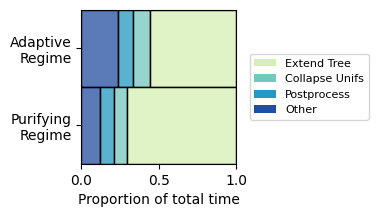

,method,category,duration (h)
0,Adaptive\nRegime,collapse_unifurcations(dropped_only=True),0.320105
1,Adaptive\nRegime,extend_tree_searchtable_cpp_from_exploded,1.602286
2,Adaptive\nRegime,postprocessing,0.290037
3,Purifying\nRegime,collapse_unifurcations(dropped_only=True),0.221350
4,Purifying\nRegime,extend_tree_searchtable_cpp_from_exploded,1.829094
5,Purifying\nRegime,postprocessing,0.220155
6,Adaptive\nRegime,other,0.673572
7,Purifying\nRegime,other,0.314263


In [4]:
summed_non_adaptive["method"] = "Purifying\nRegime"
summed_adaptive["method"] = "Adaptive\nRegime"

df_combined = pd.concat([summed_non_adaptive, summed_adaptive], ignore_index=True)
df_combined["duration (h)"] = df_combined["duration (s)"] / 3600

df_hstrat = df_combined[df_combined["what"] == "hstrat.dataframe.surface_build_tree"].copy()
total_hstrat = df_hstrat.groupby("method")["duration (h)"].sum().reset_index(name="hstrat_total_h")

df_parts = df_combined[df_combined["what"] != "hstrat.dataframe.surface_build_tree"].copy()

def recategorize(what):
    if what in [
        "extend_tree_searchtable_cpp_from_exploded",
        "collapse_unifurcations(dropped_only=True)"
    ]:
        return what
    else:
        return "postprocessing"

df_parts["category"] = df_parts["what"].apply(recategorize)

grouped_parts = df_parts.groupby(["method", "category"], as_index=False).agg({"duration (h)": "sum"})
total_parts = df_parts.groupby("method")["duration (h)"].sum().reset_index(name="parts_total_h")

total_summary = pd.merge(total_hstrat, total_parts, on="method", how="left")
total_summary["other"] = total_summary["hstrat_total_h"] - total_summary["parts_total_h"]

df_other = total_summary[["method", "other"]].copy()
df_other = df_other.rename(columns={"other": "duration (h)"})
df_other["category"] = "other"

final_df = pd.concat([grouped_parts, df_other], ignore_index=True)

def plot_billion_tip_reconstruction_fill(data):

  ordered_categories = [
      "extend_tree_searchtable_cpp_from_exploded",
      "collapse_unifurcations(dropped_only=True)",
      "postprocessing",
      "other"
  ]

  legend_labels = [
      "Extend Tree",
      "Collapse Unifs",
      "Postprocess",
      "Other"
  ]

  plt.figure(figsize=(2, 2))
  ax = sns.histplot(
      data=final_df,
      y="method",
      hue="category",
      weights="duration (h)",
      multiple="fill",
      discrete=True,
      hue_order=ordered_categories,
      palette="YlGnBu"
  )

  ax.set_xlabel("Proportion of total time")
  ax.set_ylabel("")

  palette = sns.color_palette("YlGnBu", len(ordered_categories))
  custom_handles = [
      Patch(facecolor=palette[i], label=legend_labels[i])
      for i in range(len(legend_labels))
  ]

  ax.legend(
      handles=custom_handles,
      bbox_to_anchor=(1.05, 0.5),
      loc='center left',
      fontsize=8
  )



tp.tee(
    plot_billion_tip_reconstruction_fill,
    data=final_df,
    teeplot_subdir=teeplot_subdir,
)

display(final_df[["method", "category", "duration (h)"]])


**STACKED GRAPH**


teeplots/2025-05-11-billion-tip-benchmark-v1_20_10/viz=plot-billion-tip-reconstruction-stack+ext=.pdf
teeplots/2025-05-11-billion-tip-benchmark-v1_20_10/viz=plot-billion-tip-reconstruction-stack+ext=.png


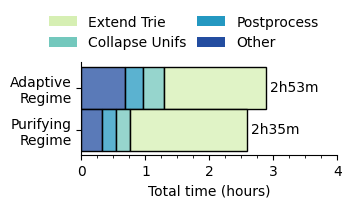

,method,category,duration (h)
0,Adaptive\nRegime,collapse_unifurcations(dropped_only=True),0.320105
1,Adaptive\nRegime,extend_tree_searchtable_cpp_from_exploded,1.602286
2,Adaptive\nRegime,postprocessing,0.290037
3,Purifying\nRegime,collapse_unifurcations(dropped_only=True),0.221350
4,Purifying\nRegime,extend_tree_searchtable_cpp_from_exploded,1.829094
5,Purifying\nRegime,postprocessing,0.220155
6,Adaptive\nRegime,other,0.673572
7,Purifying\nRegime,other,0.314263


In [5]:
import matplotlib.ticker as ticker

def plot_billion_tip_reconstruction_stack(data):

    ordered_categories = [
        "extend_tree_searchtable_cpp_from_exploded",
        "collapse_unifurcations(dropped_only=True)",
        "postprocessing",
        "other"
    ]

    legend_labels = [
        "Extend Trie",
        "Collapse Unifs",
        "Postprocess",
        "Other"
    ]

    plt.figure(figsize=(3.3, 1.2))
    ax = sns.histplot(
        data=final_df,
        y="method",
        hue="category",
        weights="duration (h)",
        multiple="stack",
        discrete=True,
        hue_order=ordered_categories,
        palette="YlGnBu"
    )

    ax.set_xlabel("Total time (hours)")
    ax.set_ylabel("")

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])

    ax.xaxis.minorticks_on()
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

    palette = sns.color_palette("YlGnBu", len(ordered_categories))
    custom_handles = [
        Patch(facecolor=palette[i], label=legend_labels[i])
        for i in range(len(legend_labels))
    ]

    ax.legend(
        handles=custom_handles,
        bbox_to_anchor=(1.05, 0.5),
        loc='center left',
        fontsize=8
    )

    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.4, 1), ncol=2, title=None, frameon=False,
        columnspacing=0.8,
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    totals = data.groupby('method')['duration (h)'].sum()
    methods = [tick.get_text() for tick in ax.get_yticklabels()]
    labels = []
    for m in methods:
        h = totals[m]
        hrs = int(h)
        mins = int(round((h - hrs) * 60))
        labels.append(f"{hrs}h{mins}m")
    ax.bar_label(ax.containers[-1], labels=labels, label_type='edge', padding=3, fontsize=10)

tp.tee(
    plot_billion_tip_reconstruction_stack,
    data=final_df,
    teeplot_subdir=teeplot_subdir,
)

display(final_df[["method", "category", "duration (h)"]])
